In [4]:
import re
import requests
import json
import sqlite3
import glob
import urllib.parse
from bs4 import BeautifulSoup
import MeCab as mc
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:

conn = None

#  データベースに接続する
def connect():
    global conn
    conn = sqlite3.connect('./sample.db')

def close():
    conn.close()
    
def create_table():
    conn.execute('DROP TABLE IF EXISTS countries')
    conn.execute("""CREATE TABLE countries (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            country_name text,
            content text
            )""")
# def create_table():
#     conn.execute('DROP TABLE IF EXISTS docs')
#     conn.execute('''CREATE TABLE IF EXISTS docs (
#             id        INTEGER PRIMARY KEY AUTOINCREMENT,
#             content   TEXT,
#             meta_info BLOB,
#             sentence  BLOB,
#             chunk     BLOB,
#             token     BLOB
#             )''')

#  Countriesテーブルにレコードを挿入
def load(name, content):
    conn.execute(
        'INSERT INTO countries (country_name, content) VALUES (?, ?)', (name, content))
    conn.commit()
    
def get(doc_id, fl):
    row_ls = conn.execute(
        'SELECT {} FROM docs WHERE id = ?'.format(','.join(fl)), (doc_id,)).fetchone()
    row_dict = {}
    for key, value in zip(fl, row_ls):
        row_dict[key] = value
    return row_dict

def get_content(name, limit, offset=0):
    return [record[0] for record in 
               conn.execute(
            'SELECT content FROM countries WHERE country_name = ? LIMIT ? OFFSET ?',
            (name, limit, offset))]

def get_all_contents(limit, offset=0):
    return [record[0] for record in 
               conn.execute(
            'SELECT content FROM countries LIMIT ? OFFSET ?',
            (limit, offset))]


In [ ]:
if __name__ == "__main__":
    connect()
    create_table()
    close()

In [27]:
url = "https://ja.wikipedia.org/wiki/%E5%9B%BD%E3%81%AE%E4%B8%80%E8%A6%A7"
header = "https://ja.wikipedia.org"

r = requests.get(url)
bs = BeautifulSoup(r.text, "html.parser")
table = bs.find("table", class_="wikitable")

connect()
create_table()
for tr in table.find_all("tr"):
    a = tr.find_all("a")
    if a:
        name = a[1].text
        link = a[1].get("href")
        res = requests.get(header + link)
        load(name, res.text)
close()

In [6]:
def get_html(name):
    connect()
    html = get_content(name=name, limit=1)
    soup = BeautifulSoup(html[0], "html.parser")
    close()
    return soup

In [7]:
def format_sentence(soup):
    content = soup.find(id="content").text
    sentence = re.sub("[[^\x01-\x7E]|\w]+", "", content)
    return sentence

In [16]:
mecab = mc.Tagger("-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -Owakati")
print(mecab.parse(sentence))

アイルランド 出典 フリー 百科事典 『 ウィキペディア （） 』 ナビゲーション に 移動 検索 に 移動 「 アイルランド 」 の その他 の 用法 について は 「 アイルランド 曖昧さ回避 」 を ご覧 ください 。 「 アイリッシュ 」 は この 項目 へ 転送 さ れ て い ます 。 その他 の 用法 について は 「 アイリッシュ 曖昧さ回避 」 を ご覧 ください 。 「 アイルランド共和国 」 は この 項目 へ 転送 さ れ て い ます 。 アイルランド独立戦争 期 に 独立 が 宣言 さ れ た 国家 について は 「 アイルランド共和国 」 を ご覧 ください 。 アイルランド É （ アイルランド語 ） （ 英語 ） （ 国旗 ） （ 国章 ） 国 の 標語 ： É （ アイルランド語 アイルランド よ 、 永遠に ） 国歌 ： á （ アイルランド語 ） ’ （ 英語 ） 兵士の歌 公用語 アイルランド語 、 英語 首都 ダブリン 最大 の 都市 ダブリン 政府 大統領 マイケル ・ ・ ヒギンズ 首相 レオ・ヴァラッカー 面積 総計 （ 位 ） 水面 積 率 人口 総計 （ 年 ） 人 （ 位 ） 人口密度 人 （ 自国通貨 表示 ） 合計 （ 年 ） 億 ユーロ € 合計 （ 年 ） 億 ドル （ 位 ） 合計 （ 年 ） 億 ドル （ 位 ） 人 あたり ドル 独立 年月日 （ アイルランド自由国 ） 年月日 （ アイルランド憲法 の 施行 ） 年月日 （ イギリス連邦 を 離脱 ） 通貨 ユーロ € 時間帯 ±（：） 国際電話 番号 年月日 閲覧 （） 年 以前 の 通貨 は アイルランド・ポンド 。 アイルランドのユーロ硬貨 も 参照 。 アイルランド 、 または アイルランド共和国 （ アイルランド きょう わ こく ） は 、 北西 ヨーロッパ 、 北大西洋 の アイルランド島 の 大 部分 を 領土 と する 立憲 共和制 国家 。 首都 は ダブリン 。 島 の 北東部 は イギリスのカントリー の 一つ で ある 北アイルランド と 接し て いる 。 独立 前 より 北アイルランド も 自国 の 領土 で ある と 主張 し 、 イギリス と の 対立 と 抗争 を 繰り返し て き た が 、 年 の ベルファ

In [9]:
def mecab_analysis(texts):
    t = mc.Tagger("-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")
    t.parse('')
    output = []
    node =  t.parseToNode(texts)  
    while node:
        if node.surface != "":  # ヘッダとフッタを除外
            word_type = node.feature.split(",")[0]
            if word_type in ['名詞']:
                output.append(node.surface)
        node = node.next
        if node is None:
            break
    return output


In [18]:
counter = Counter(mecab_analysis(sentence))
sorted_list = sorted(counter.items(), key=lambda x:x[1], reverse=True)

In [19]:
string = " ".join(mecab_analysis(sentence))

fpath = "/home/y-watanabe/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf"
word_list = ["現在", "閲覧", "年月日", "これ", "参照", "それ", "表記", "詳細", "影響", "地域", "項目", "こと", "よう", "年月", "および",
             "以降", "一部", "その後", "ため", "もの", "使用", "多く", "所蔵", "近年", "場合", "中心", "時点", "一覧", "規定", "その他"]
wordcloud = WordCloud(
    background_color="black",
    stopwords=word_list,
    font_path=fpath,
    max_words=70,
    width=800,
    collocations = False,
    height=600).generate(string)

アイルランド 出典 フリー 百科事典 ウィキペディア （） ナビゲーション 移動 検索 移動 アイルランド その他 用法 アイルランド 曖昧さ回避 ご覧 アイリッシュ 項目 転送 その他 用法 アイリッシュ 曖昧さ回避 ご覧 アイルランド共和国 項目 転送 アイルランド独立戦争 期 独立 宣言 国家 アイルランド共和国 ご覧 アイルランド É アイルランド語 英語 国旗 国章 国 標語 É アイルランド語 アイルランド 永遠に 国歌 á アイルランド語 英語 兵士の歌 公用語 アイルランド語 英語 首都 ダブリン 最大 都市 ダブリン 政府 大統領 マイケル ヒギンズ 首相 レオ・ヴァラッカー 面積 総計 位 水面 積 率 人口 総計 年 人 位 人口密度 人 自国通貨 表示 合計 年 億 ユーロ € 合計 年 億 ドル 位 合計 年 億 ドル 位 人 あたり ドル 独立 年月日 アイルランド自由国 年月日 アイルランド憲法 施行 年月日 イギリス連邦 離脱 通貨 ユーロ € 時間帯 国際電話 番号 年月日 閲覧 （） 年 以前 通貨 アイルランド・ポンド アイルランドのユーロ硬貨 参照 アイルランド アイルランド共和国 アイルランド きょう 北西 ヨーロッパ 北大西洋 アイルランド島 部分 領土 立憲 共和制 国家 首都 ダブリン 島 北東部 イギリスのカントリー 一つ 北アイルランド 独立 前 北アイルランド 自国 領土 主張 イギリス 対立 抗争 年 ベルファスト合意 領有権 放棄 年 エコノミスト 調査 国 選出 目次 国名 歴史 古代 ノルマン人 侵入 宗教改革 プロテスタント 支配 強化 植民地時代 アイルランド独立戦争 アイルランド内戦 政治 治安 軍事 国際関係 イギリス 関係 アメリカ合衆国 関係 日本 行政区画 主要 都市 地理 経済 農業 鉱業 交通 国民 言語 宗教 婚姻 保健 教育 文化 食文化 文学 音楽 美術 芸能 映画 世界遺産 祝祭日 スポーツ 国技 サッカー ラグビー 競馬 ゴルフ 野球 著名 出身 者 脚注 参考文献 関連 項目 外部 リンク 国名 編 詳細 アイルランド 国名 英語版 参照 アイルランド 地図 憲法 正式名称 アイルランド語 É 音声 ファイル エァル 英語 アィアランド 国際連合 欧州連合 では 国名 登録 

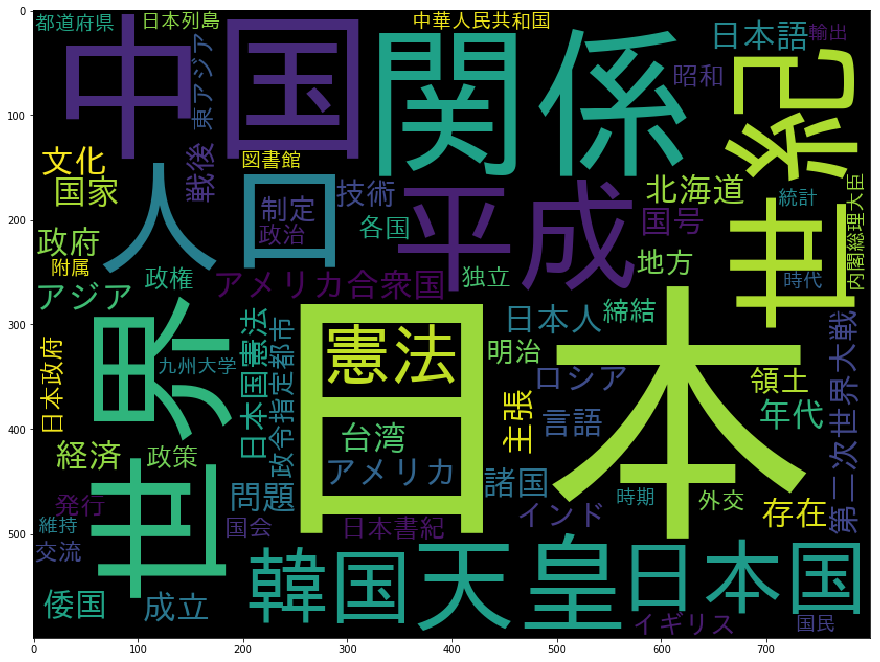

In [70]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)

In [58]:
import matplotlib as mpl
print(mpl.matplotlib_fname())

/home/y-watanabe/.local/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


In [36]:
ice = format_sentence(get_html("アイスランド共和国"))
# ice = string = " ".join(mecab_analysis(ice))
ice = mecab_analysis(ice)
# ice = [m.encode() for m in mecab_analysis(ice)]
ire = format_sentence(get_html("アイルランド"))
# ire = string = " ".join(mecab_analysis(ire))
ire = mecab_analysis(ire)
content_list = [ice, ire]
print(content_list)

[['アイスランド', '出典', 'フリー', '百科事典', 'ウィキペディア', '（）', 'ナビゲーション', '移動', '検索', '移動', 'アイスランド共和国', 'Í', '国旗', '国章', '国', '標語', '国歌', 'ö', 'アイスランド語', '賛美歌', '公用語', 'アイスランド語', '首都', 'レイキャビク', '最大', '都市', 'レイキャビク', '政府', '大統領', 'グズニ・ヨハンネソン', '首相', 'カトリーン・ヤコブスドッティル', '面積', '総計', '位', '水面', '積', '率', '人口', '総計', '年', '人', '位', '人口密度', '人', '自国通貨', '表示', '合計', '年', '億', 'アイスランド・クローナ', '合計', '年', 'ドル', '位', '合計', '年', 'ドル', '位', '人', 'あたり', 'ドル', '独立', 'デンマーク', '年月日', '通貨', 'アイスランド・クローナ', '時間帯', '国際電話', '番号', 'アイスランド', '北ヨーロッパ', '北大西洋', '上', '位置', '共和制', '国家', '首都', 'レイキャビク', '人口', '人', '目次', '概要', '国名', '歴史', '植民', '自然', '影響', '新天地', '自治', '終焉', '独立運動', '政治', '加盟', '問題', '背景', '加盟', '申請', '加盟', '交渉開始', '加盟', '申請', '取り下げ', 'エネルギー政策', '捕鯨', '軍事', '地方行政', '区分', '市', '地理', '火山', '主', '湖', '主', '山気', '候', '都市', '交通', '経済', '国家', '経済', '金融危機', '以前', '金融危機', '以後', '資源', '漁業', 'エネルギー', '製造業', '商業', '貿易', '国民', '人口統計', '言語', '宗教教育', '人名', '同性婚', '文化', '食文化', '文学', 'スポーツ', '音楽', '世界遺産', '祝祭日', '出身', '人物', '映

In [48]:
vectorizer = TfidfVectorizer(analyzer="word", max_df=0.9)
vecs = vectorizer.fit_transform(content_list)
vectorizer.get_feature_names()

['áé',
 'áéá',
 'áí',
 'ðáð',
 'ðþóð',
 'óá',
 'óó',
 'ýððí',
 'þóð',
 'þóþ',
 'あと',
 'いずれ',
 'いた事',
 'うち',
 'お湯',
 'お茶',
 'から',
 'きょう',
 'きれいな',
 'くない',
 'この国',
 'ごと',
 'ごろ',
 'ご覧',
 'さい',
 'さまざま',
 'さら',
 'した仕事',
 'しょ',
 'すべて',
 'すみやか',
 'それぞれ',
 'それら',
 'である',
 'ところ',
 'ないし',
 'のち',
 'ひとつ',
 'ほか',
 'ゆえ',
 'わけ',
 'わし',
 'われわれ',
 'アィアランド',
 'アイス',
 'アイスランドのフィヨルド',
 'アイスランドの世界遺産',
 'アイスランドの地域区分',
 'アイスランドの地方',
 'アイスランドの地理',
 'アイスランドの歴史',
 'アイスランドの氷河',
 'アイスランドの河川',
 'アイスランドの湖',
 'アイスランドの滝',
 'アイスランドの火山活動',
 'アイスランドの自治体',
 'アイスランドプルーム',
 'アイスランドホットスポット',
 'アイスランド中央銀行',
 'アイスランド中央高地',
 'アイスランド人',
 'アイスランド人の名前',
 'アイスランド共和国',
 'アイスランド王国',
 'アイスランド航空',
 'アイスランド語',
 'アイスランド防衛隊',
 'アイデンティティ',
 'アイリッシュ',
 'アイリッシュダンス',
 'アイリッシュダービー',
 'アイリッシュパブ',
 'アイリッシュメン',
 'アイリッシュ海',
 'アイルランドのカトリック',
 'アイルランドのユーロ硬貨',
 'アイルランドの世界遺産',
 'アイルランドの地方',
 'アイルランドの地方行政区画',
 'アイルランドの競馬',
 'アイルランドの経済',
 'アイルランド併合',
 'アイルランド共和国',
 'アイルランド内戦',
 'アイルランド卿',
 'アイルランド国教会',
 'アイルランド国防軍',
 'アイルランド大統領',
 'アイルランド島',
 'アイルランド憲法

In [2]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

In [54]:
dictionary = Dictionary(content_list)
# dictionary.filter_extremes(no_below=2, no_above=0.3)
corpus = [dictionary.doc2bow(doc) for doc in content_list]
lda = LdaModel(corpus, num_topics=2, id2word=dictionary, passes=10)

In [56]:
for topic in lda.show_topics(num_topics=-1, num_words=20):
    print("topic id:{0[0]}, words={0[1]}".format(topic))
#     print(topic)

topic id:0, words=0.026*"アイルランド" + 0.016*"年" + 0.011*"編" + 0.009*"英語版" + 0.008*"州" + 0.008*"イギリス" + 0.007*"参照" + 0.007*"アイルランド語" + 0.006*"詳細" + 0.005*"年月日" + 0.005*"英語" + 0.005*"アイルランド人" + 0.004*"国" + 0.004*"こと" + 0.003*"多く" + 0.003*"経済" + 0.003*"的" + 0.003*"閲覧" + 0.003*"万" + 0.003*"人"
topic id:1, words=0.027*"アイスランド" + 0.012*"編" + 0.011*"年" + 0.009*"加盟" + 0.007*"年月日" + 0.006*"参照" + 0.005*"詳細" + 0.005*"ため" + 0.005*"こと" + 0.005*"年月" + 0.004*"英語版" + 0.004*"経済" + 0.004*"の" + 0.004*"漁業" + 0.003*"国" + 0.003*"世界" + 0.003*"デンマーク" + 0.003*"閲覧" + 0.003*"これ" + 0.003*"よう"


In [53]:
ice

['アイスランド',
 '出典',
 'フリー',
 '百科事典',
 'ウィキペディア',
 '（）',
 'ナビゲーション',
 '移動',
 '検索',
 '移動',
 'アイスランド共和国',
 'Í',
 '国旗',
 '国章',
 '国',
 '標語',
 '国歌',
 'ö',
 'アイスランド語',
 '賛美歌',
 '公用語',
 'アイスランド語',
 '首都',
 'レイキャビク',
 '最大',
 '都市',
 'レイキャビク',
 '政府',
 '大統領',
 'グズニ・ヨハンネソン',
 '首相',
 'カトリーン・ヤコブスドッティル',
 '面積',
 '総計',
 '位',
 '水面',
 '積',
 '率',
 '人口',
 '総計',
 '年',
 '人',
 '位',
 '人口密度',
 '人',
 '自国通貨',
 '表示',
 '合計',
 '年',
 '億',
 'アイスランド・クローナ',
 '合計',
 '年',
 'ドル',
 '位',
 '合計',
 '年',
 'ドル',
 '位',
 '人',
 'あたり',
 'ドル',
 '独立',
 'デンマーク',
 '年月日',
 '通貨',
 'アイスランド・クローナ',
 '時間帯',
 '国際電話',
 '番号',
 'アイスランド',
 '北ヨーロッパ',
 '北大西洋',
 '上',
 '位置',
 '共和制',
 '国家',
 '首都',
 'レイキャビク',
 '人口',
 '人',
 '目次',
 '概要',
 '国名',
 '歴史',
 '植民',
 '自然',
 '影響',
 '新天地',
 '自治',
 '終焉',
 '独立運動',
 '政治',
 '加盟',
 '問題',
 '背景',
 '加盟',
 '申請',
 '加盟',
 '交渉開始',
 '加盟',
 '申請',
 '取り下げ',
 'エネルギー政策',
 '捕鯨',
 '軍事',
 '地方行政',
 '区分',
 '市',
 '地理',
 '火山',
 '主',
 '湖',
 '主',
 '山気',
 '候',
 '都市',
 '交通',
 '経済',
 '国家',
 '経済',
 '金融危機',
 '以前',
 '金融危機',
 '以後',
 '資源',
 '漁業',
 'エネルギ